Black–Scholes (European call): 10.450584
N=5     Binomial=10.805934  |Error|=3.553503e-01
N=10    Binomial=10.253409  |Error|=1.971745e-01
N=20    Binomial=10.351260  |Error|=9.932338e-02
N=40    Binomial=10.400751  |Error|=4.983209e-02
N=80    Binomial=10.425627  |Error|=2.495687e-02
N=160   Binomial=10.438095  |Error|=1.248841e-02
N=320   Binomial=10.444337  |Error|=6.246673e-03
N=640   Binomial=10.447460  |Error|=3.123949e-03


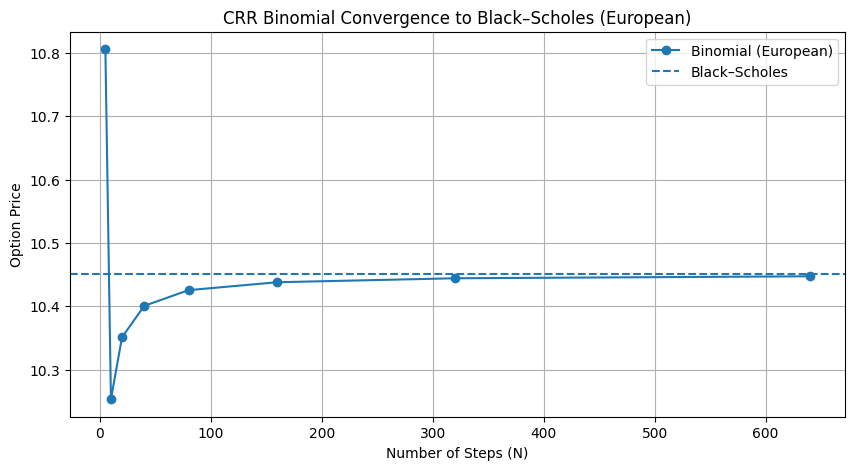

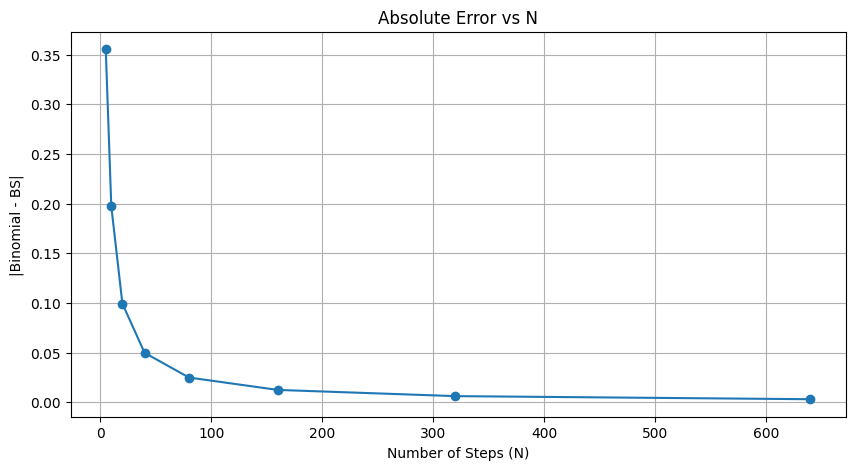

In [2]:
# 02_binomial_tree.ipynb — Cell 1: Convergence with sample parameters

import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src"))
from binomial import crr_price
from bs import black_scholes_price  # already in your repo
import numpy as np

# ---------- Sample Parameters ----------
S = 100.0
K = 100.0
r = 0.05
q = 0.00
sigma = 0.20
T = 1.0
option = "call"

# Black–Scholes benchmark (European)
bs_price_euro = black_scholes_price(S, K, T, r, sigma, option_type=option)
print(f"Black–Scholes (European {option}): {bs_price_euro:.6f}")

# Convergence study over N
Ns = [5, 10, 20, 40, 80, 160, 320, 640]
binom_prices = []
abs_errors = []

for N in Ns:
    priceN = crr_price(S, K, r, q, sigma, T, N=N, option=option, american=False)
    binom_prices.append(priceN)
    abs_errors.append(abs(priceN - bs_price_euro))

# Display results
for N, p, e in zip(Ns, binom_prices, abs_errors):
    print(f"N={N:<4}  Binomial={p:.6f}  |Error|={e:.6e}")

# ---------- Plots ----------
plt.figure(figsize=(10,5))
plt.plot(Ns, binom_prices, marker='o', label='Binomial (European)')
plt.axhline(bs_price_euro, linestyle='--', label='Black–Scholes')
plt.title('CRR Binomial Convergence to Black–Scholes (European)')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(Ns, abs_errors, marker='o')
plt.title('Absolute Error vs N')
plt.xlabel('Number of Steps (N)')
plt.ylabel('|Binomial - BS|')
plt.grid(True); plt.show()


Dropdown(description='Stock:', options=('AAPL', 'NFLX', 'PLTR', 'NVDA', 'META', 'AMZN'), value='AAPL')


Selected: AAPL | Current Price: 238.47
Expiry: 2025-09-05, Strike: 237.5, Market Price: 2.50, T=0.003y
Black–Scholes (call): 1.5745


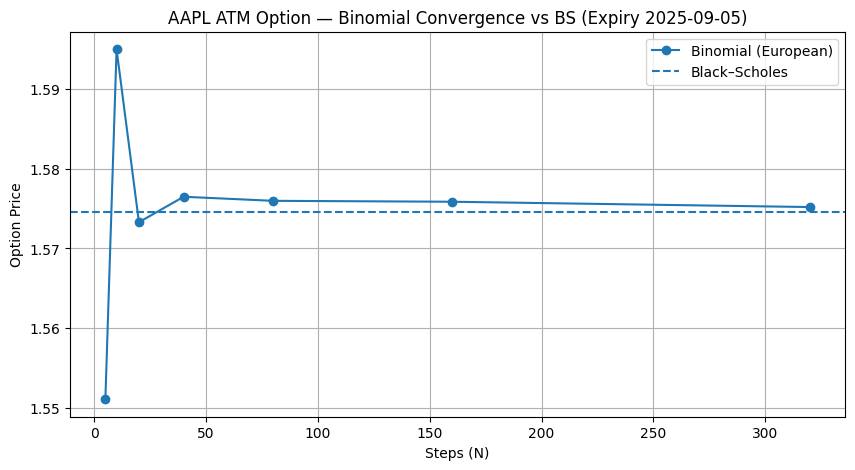

In [3]:
import yfinance as yf
import datetime
import ipywidgets as widgets
from IPython.display import display

# List of stocks
stock_list = ["AAPL", "NFLX", "PLTR", "NVDA", "META", "AMZN"]

# Dropdown for stock selection
dropdown = widgets.Dropdown(
    options=stock_list,
    description='Stock:',
    value="AAPL"  # default
)
display(dropdown)

# --- Wrap selection in yfinance
ticker_symbol = dropdown.value
ticker = yf.Ticker(ticker_symbol)

# Current stock price
S = ticker.history(period="1d")["Close"].iloc[-1]
print(f"\nSelected: {ticker_symbol} | Current Price: {S:.2f}")

# --- Get option chain (nearest expiry, if available)
if ticker.options:
    expiries = ticker.options
    expiry = expiries[0]
    opt_chain = ticker.option_chain(expiry)
    calls = opt_chain.calls

    # Pick ATM strike
    atm_row = calls.iloc[(calls['strike'] - S).abs().argsort()[:1]]
    K = atm_row['strike'].values[0]
    market_price = atm_row['lastPrice'].values[0]

    # Time to expiry (years)
    today = datetime.date.today()
    expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d").date()
    T = (expiry_date - today).days / 365

    # Risk-free rate (assume constant)
    r = 0.05
    q = 0.00
    sigma_guess = 0.2  # initial guess for CRR/BS (later you can plug implied vol)

    print(f"Expiry: {expiry}, Strike: {K}, Market Price: {market_price:.2f}, T={T:.3f}y")

    # --- Prices
    bs_val = black_scholes_price(S, K, T, r, sigma_guess, option_type="call")
    print(f"Black–Scholes (call): {bs_val:.4f}")

    Ns = [5, 10, 20, 40, 80, 160, 320]
    binom_vals = [crr_price(S, K, r, q, sigma_guess, T, N=N, option="call", american=False) for N in Ns]

    # --- Plot convergence
    plt.figure(figsize=(10,5))
    plt.plot(Ns, binom_vals, marker='o', label='Binomial (European)')
    plt.axhline(bs_val, linestyle='--', label='Black–Scholes')
    plt.title(f"{ticker_symbol} ATM Option — Binomial Convergence vs BS (Expiry {expiry})")
    plt.xlabel("Steps (N)")
    plt.ylabel("Option Price")
    plt.grid(True); plt.legend(); plt.show()
else:
    print(f"{ticker_symbol} has no option chain available on Yahoo Finance.")
